In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import os
from supervised.automl import AutoML
import category_encoders as ce
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.metrics import median_absolute_error
print('Imported sci-kit learn and AutoML libraries!')

Imported sci-kit learn and AutoML libraries!


## Prediction with explainable AI - Cork City - Economic Test

Let's use this file to predict the prices of houses in Cork City and use explainable AI such as SHAP values to explain the determinants of prices in Cork City. We will then compare this to the same experiment we ran with selected areas of Dublin City. We will use some economic variables such as unemployment number, government deficit and household disposable income with this trial here.

In [2]:
# cork-more-fixed.csv
irl =  pd.read_csv('consumer-interest-cork.csv', index_col = 'Unnamed: 0')

In [3]:
irl.head(1)

,Address,County,Price (€),VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Apartment,...,Latitude,Longitude,DistanceCenter,DistanceSchool,DistancePark,DistanceCar,Unemployment Number,Household Disposable,Gov Deficit,Interest Consumer
0,"10 Deerpark Court, Friars Walk, Cork",Cork,280000.0,1,1,2,2014,1,Cork City,0,...,51.891104,-8.474261,0.808257,0.371367,0.334321,0.607264,1.960538,22610.0,-0.695419,5.19


In [4]:
irl.columns

Index(['Address', 'County', 'Price (€)', 'VAT Exclusive',
       'Description of Property', 'Property Size Description', 'Year', 'Month',
       'Town', 'Apartment', 'Neighbourhood', 'PriceInflation', 'Eircode',
       'Latitude', 'Longitude', 'DistanceCenter', 'DistanceSchool',
       'DistancePark', 'DistanceCar', 'Unemployment Number',
       'Household Disposable', 'Gov Deficit', 'Interest Consumer'],
      dtype='object')

In [5]:
irl.drop(columns = ['VAT Exclusive', 'County', 'Address', 'Eircode', 'PriceInflation'], inplace = True)

In [6]:
irl.columns

Index(['Price (€)', 'Description of Property', 'Property Size Description',
       'Year', 'Month', 'Town', 'Apartment', 'Neighbourhood', 'Latitude',
       'Longitude', 'DistanceCenter', 'DistanceSchool', 'DistancePark',
       'DistanceCar', 'Unemployment Number', 'Household Disposable',
       'Gov Deficit', 'Interest Consumer'],
      dtype='object')

In [7]:
encoder = TargetEncoder()
irl['Neighbourhood'] = encoder.fit_transform(irl['Neighbourhood'], irl['Price (€)'])

In [8]:
encoder = TargetEncoder()
irl['Town'] = encoder.fit_transform(irl['Town'], irl['Price (€)'])

In [9]:
# predicting standard
irl['LogPrice (€)'] = np.log(irl['Price (€)'])
irl.drop(columns = ['Price (€)'], inplace = True)
irl.head()

,Description of Property,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,Latitude,Longitude,DistanceCenter,DistanceSchool,DistancePark,DistanceCar,Unemployment Number,Household Disposable,Gov Deficit,Interest Consumer,LogPrice (€)
0,1,2,2014,1,236733.146226,0,216038.432676,51.891104,-8.474261,0.808257,0.371367,0.334321,0.607264,1.960538,22610.0,-0.695419,5.19,12.542545
1,1,1,2014,1,236733.146226,0,342433.937408,51.844802,-8.312442,12.501636,0.597510,5.440909,11.244529,1.960538,22610.0,-0.695419,5.19,12.821258
2,1,1,2014,1,236733.146226,0,143121.870690,51.903869,-8.471192,0.626745,0.323214,0.129914,0.238164,1.960538,22610.0,-0.695419,5.19,11.775290
3,1,1,2014,1,236733.146226,0,247114.496667,51.911380,-8.450581,2.096941,0.447549,0.669517,1.805214,1.960538,22610.0,-0.695419,5.19,11.951180
4,1,1,2014,1,231996.122449,0,231996.122449,51.882655,-8.507208,2.943974,0.503091,0.823622,2.329469,1.960538,22610.0,-0.695419,5.19,12.254863


In [10]:
# this function finds all values that fall within internationally accepted +-10% of actual prices in our predictions
# we can modify the threshold as we feel the need to here
def accuracy_threshold(test, pred, num):
    test = np.array(test)
    pred = np.array(pred)
# get within x% of actual price , not within log price as this will be misleading / incorrect
    test = np.exp(test)
    pred = np.exp(pred)
    count = 0
    for i in range(len(pred)):
        if test[i] != 0:  
            ten = test[i] * num
            res = test[i] - pred[i]
        else:
            res = 0
            ten = 0
        
        if res < 0:
            res = res * -1
        else:
            res = res
            
        if res <= ten:
            count += 1
        else:
            continue
    return (count / len(test))

In [11]:
from tpot import TPOTRegressor
from sklearn.model_selection import RepeatedKFold

## 2021

### TPOT

In [12]:
specific21 = irl[irl['Year'] > 2017]

In [13]:
train_21 = specific21[specific21['Year'] < 2021]

In [14]:
test_21 = specific21[specific21['Year'] == 2021]

In [15]:
x_train_21 = train_21.loc[:, train_21.columns != 'LogPrice (€)']
y_train_21 = train_21['LogPrice (€)']

In [16]:
x_test_21 = test_21.loc[:, test_21.columns != 'LogPrice (€)']
y_test_21 = test_21['LogPrice (€)']

In [17]:
#cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
# define search
model = TPOTRegressor(max_time_mins = 6)
model1 = model.fit(x_train_21, y_train_21)

In [18]:
#model1.export('tpot_2021_pipeline.py')

In [19]:
# calculated values
from sklearn.metrics import mean_squared_error
y_predicted_21 = model1.predict(x_test_21)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_predicted_21)
print('MSE for TPOT AutoML 2021 is: ' + str(mse))

MSE for TPOT AutoML 2021 is: 0.1571006869017294


In [20]:
rmse = mean_squared_error(y_test_21, y_predicted_21, squared=False)
print('RMSE for TPOT AutoML 2021 is: ' + str(rmse))

RMSE for TPOT AutoML 2021 is: 0.3963592901670521


In [21]:
median_se = np.square(np.subtract(y_test_21, y_predicted_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.19954625012622182


In [22]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_21, y_predicted_21)
print("MAPE for TPOT AutoML 2021 is: " + str(mape))

MAPE for TPOT AutoML 2021 is: 0.02262528157185971


In [23]:
acc = accuracy_threshold(y_test_21, y_predicted_21, 0.1)

In [24]:
%%capture
import shap
explainer = shap.Explainer(model1.predict, x_test_21)
shap_values = explainer(x_test_21)

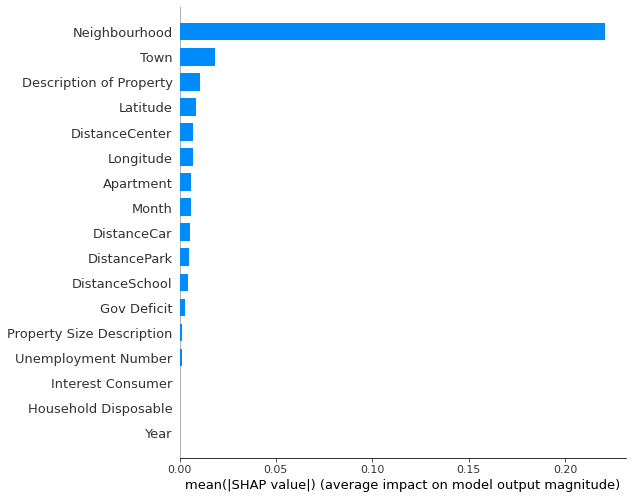

In [25]:
shap.summary_plot(shap_values, x_test_21, plot_type = 'bar')

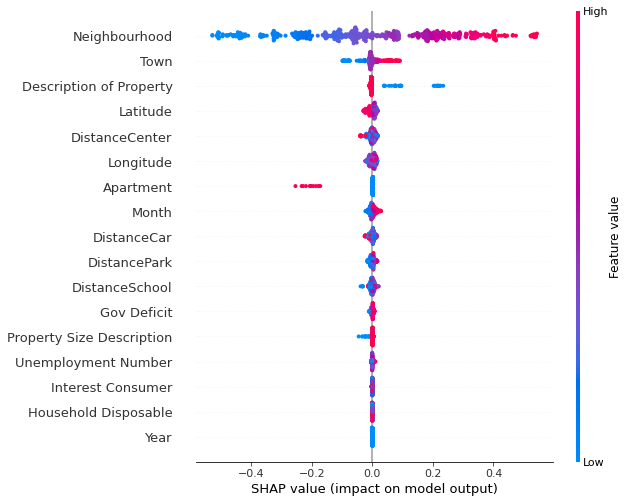

In [26]:
f = plt.figure()
shap.summary_plot(shap_values, x_test_21)
f.savefig("summary_plot21cork.png", bbox_inches = 'tight', dpi = 600)

In [27]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df11 = pd.DataFrame(columns=cnames)

df11 = df11.append({'Algorithm': 'TPOT AutoML',
            'Year': 2021,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [28]:
dfreal1 = pd.DataFrame(y_test_21.values)
dfpred1 = pd.DataFrame(y_predicted_21)

### 2020

In [29]:
specific20 = irl[irl['Year'] > 2016]

In [30]:
test_20 = specific20[specific20['Year'] == 2020]
train_20 = specific20[specific20['Year'] < 2020]

x_train_20 = train_20.loc[:, train_20.columns != 'LogPrice (€)']
y_train_20 = train_20['LogPrice (€)']

x_test_20 = test_20.loc[:, test_20.columns != 'LogPrice (€)']
y_test_20 = test_20['LogPrice (€)']

In [31]:
model = TPOTRegressor(max_time_mins = 6)
model2 = model.fit(x_train_20, y_train_20)

In [32]:
#model2.export('tpot_2020_pipeline.py')

In [33]:
y_predicted_20 = model1.predict(x_test_20)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_predicted_20)
print('MSE for TPOT AutoML 2020 is: ' + str(mse))

MSE for TPOT AutoML 2020 is: 0.13095722233315987


In [34]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_20, y_predicted_20)
print("MAPE for TPOT AutoML 2020 is: " + str(mape))

MAPE for TPOT AutoML 2020 is: 0.019689112094547163


In [35]:
median_se = np.square(np.subtract(y_test_20, y_predicted_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.15031217524067547


In [36]:
rmse = mean_squared_error(y_test_20, y_predicted_20, squared=False)
print('RMSE for TPOT AutoML 2020 is: ' + str(rmse))

RMSE for TPOT AutoML 2020 is: 0.36188012149489485


In [37]:
acc = accuracy_threshold(y_test_20, y_predicted_20, 0.1)

In [38]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df12 = pd.DataFrame(columns=cnames)

df12 = df12.append({'Algorithm': 'TPOT AutoML',
            'Year': 2020,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [39]:
dfreal2 = pd.DataFrame(y_test_20.values)
dfpred2 = pd.DataFrame(y_predicted_20)

In [40]:
%%capture
explainer = shap.Explainer(model2.predict, x_test_20)
shap_values2 = explainer(x_test_20)

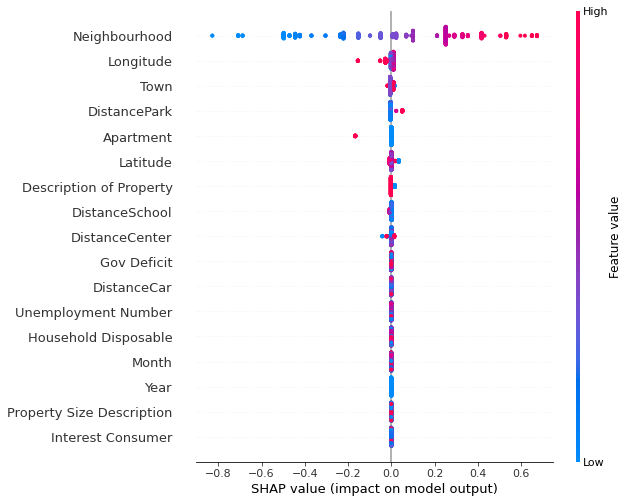

In [41]:
f = plt.figure()
shap.summary_plot(shap_values2, x_test_20)
f.savefig("summary_plot20cork.png", bbox_inches = 'tight', dpi = 600)

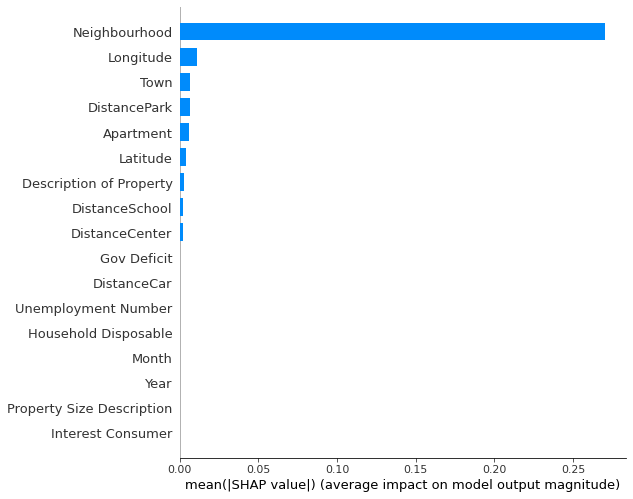

In [42]:
shap.summary_plot(shap_values2, x_test_20, plot_type = 'bar')

### 2019

In [43]:
specific19 = irl[irl['Year'] > 2015]

In [44]:
test_19 = specific19[specific19['Year'] == 2019]
train_19 = specific19[specific19['Year'] < 2019]
x_train_19 = train_19.loc[:, train_19.columns != 'LogPrice (€)']
y_train_19 = train_19['LogPrice (€)']
x_test_19 = test_19.loc[:, test_19.columns != 'LogPrice (€)']
y_test_19 = test_19['LogPrice (€)']

In [45]:
model = TPOTRegressor(max_time_mins = 6)
# perform the search // takes ages to run!
model3 = model.fit(x_train_19, y_train_19)

In [46]:
#model3.export('tpot_2019_pipeline.py')

In [47]:
y_predicted_19 = model1.predict(x_test_19)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_predicted_19)
print('MSE for TPOT AutoML 2019 is: ' + str(mse))

MSE for TPOT AutoML 2019 is: 0.12842145248214493


In [48]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_19, y_predicted_19)
print("MAPE for TPOT AutoML 2019 is: " + str(mape))

MAPE for TPOT AutoML 2019 is: 0.019697797084388426


In [49]:
median_se = np.square(np.subtract(y_test_19, y_predicted_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.16105427692408014


In [50]:
rmse = mean_squared_error(y_test_19, y_predicted_19, squared = False)
print('RMSE for TPOT AutoML 2019 is: ' + str(rmse))

RMSE for TPOT AutoML 2019 is: 0.3583593901129771


In [51]:
acc = accuracy_threshold(y_test_19, y_predicted_19, 0.1)

In [52]:
%%capture
explainer = shap.Explainer(model3.predict, x_test_19)
shap_values3 = explainer(x_test_19)

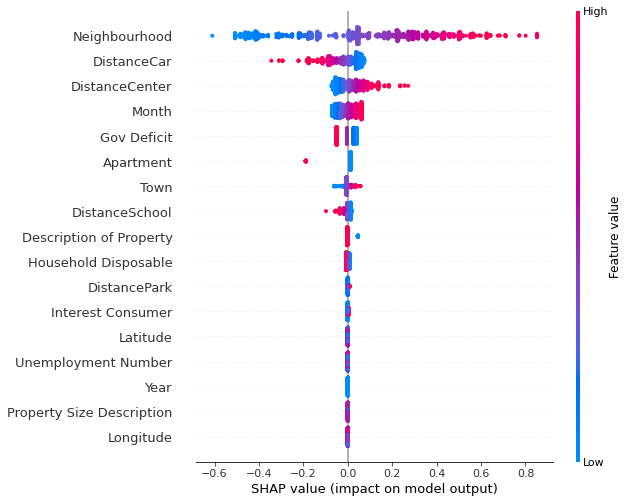

In [53]:
f = plt.figure()
shap.summary_plot(shap_values3, x_test_19)
f.savefig("summary_plot19cork.png", bbox_inches = 'tight', dpi = 600)

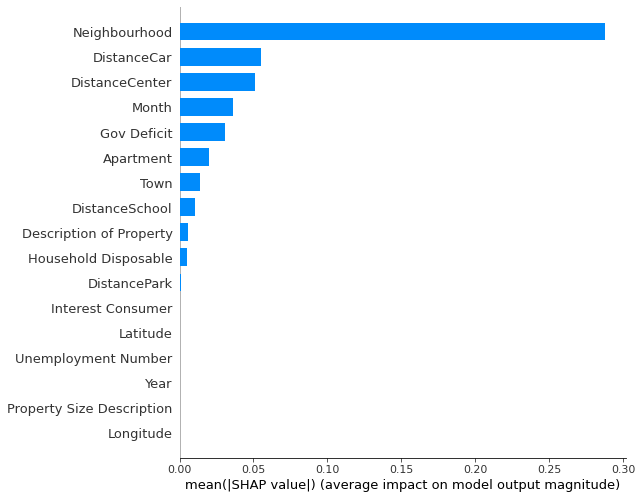

In [54]:
shap.summary_plot(shap_values3, x_test_19, plot_type = 'bar')

In [55]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df13 = pd.DataFrame(columns = cnames)

df13 = df13.append({'Algorithm': 'TPOT AutoML',
            'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [56]:
dfreal3 = pd.DataFrame(y_test_19.values)
dfpred3 = pd.DataFrame(y_predicted_19)

### 2018

In [57]:
specific18 = irl[irl['Year'] > 2014]
test_18 = specific18[specific18['Year'] == 2018]
train_18 = specific18[specific18['Year'] < 2018]

x_train_18 = train_18.loc[:, train_18.columns != 'LogPrice (€)']
y_train_18 = train_18['LogPrice (€)']
x_test_18 = test_18.loc[:, test_18.columns != 'LogPrice (€)']
y_test_18 = test_18['LogPrice (€)']

In [58]:
model = TPOTRegressor(max_time_mins = 6)
# perform the search // takes ages to run!
model4 = model.fit(x_train_18, y_train_18)

In [59]:
#model4.export('tpot_2018_pipeline.py')

In [60]:
y_predicted_18 = model1.predict(x_test_18)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_predicted_18)
print('MSE for TPOT AutoML 2018 is: ' + str(mse))

MSE for TPOT AutoML 2018 is: 0.14537204258790914


In [61]:
rmse = mean_squared_error(y_test_18, y_predicted_18, squared = False)
print('RMSE for TPOT AutoML 2018 is: ' + str(rmse))

RMSE for TPOT AutoML 2018 is: 0.38127685818563545


In [62]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_18, y_predicted_18)
print("MAPE for TPOT AutoML 2018 is: " + str(mape))

MAPE for TPOT AutoML 2018 is: 0.022291233283624336


In [63]:
median_se = np.square(np.subtract(y_test_18, y_predicted_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.18302142369007712


In [64]:
acc = accuracy_threshold(y_test_18, y_predicted_18, 0.1)

In [65]:
%%capture
explainer = shap.Explainer(model4.predict, x_test_18)
shap_values4 = explainer(x_test_18)

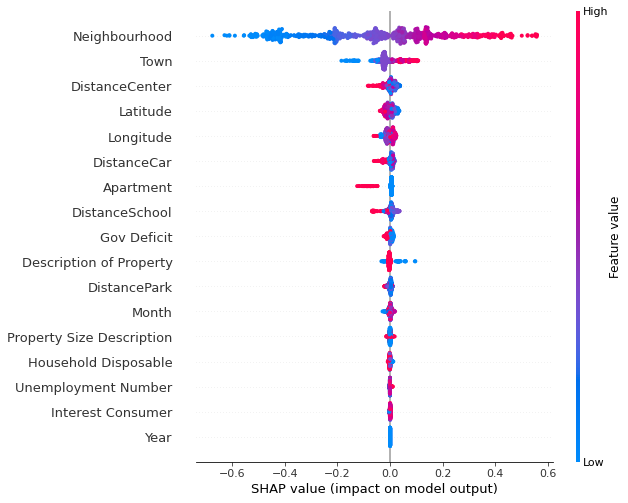

In [66]:
f = plt.figure()
shap.summary_plot(shap_values4, x_test_18)
f.savefig("summary_plot18cork.png", bbox_inches = 'tight', dpi = 600)

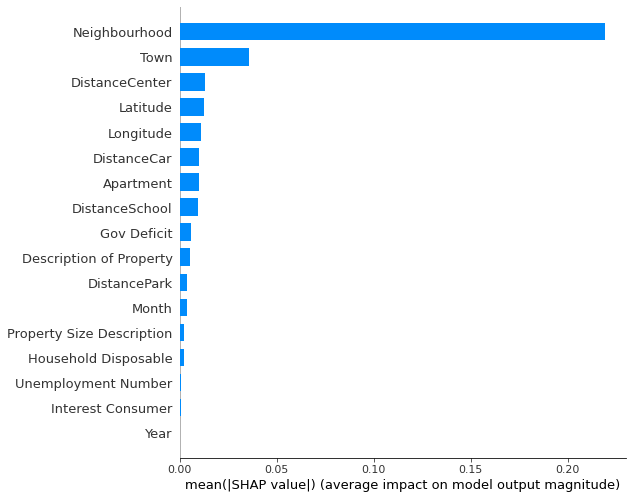

In [67]:
shap.summary_plot(shap_values4, x_test_18, plot_type = 'bar')

In [68]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df14 = pd.DataFrame(columns=cnames)

df14 = df14.append({'Algorithm': 'TPOT AutoML',
            'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [69]:
dfreal4 = pd.DataFrame(y_test_18.values)
dfpred4 = pd.DataFrame(y_predicted_18)

### 2017

In [70]:
specific17 = irl[irl['Year'] > 2013]
test_17 = specific17[specific17['Year'] == 2017]
train_17 = specific17[specific17['Year'] < 2017]

x_train_17 = train_17.loc[:, train_17.columns != 'LogPrice (€)']
y_train_17 = train_17['LogPrice (€)']
x_test_17 = test_17.loc[:, test_17.columns != 'LogPrice (€)']
y_test_17 = test_17['LogPrice (€)']

In [71]:
model = TPOTRegressor(max_time_mins = 6)
# perform the search // takes ages to run!
model5 = model.fit(x_train_17, y_train_17)

In [72]:
#model5.export('tpot_2017_pipeline.py')

In [73]:
y_predicted_17 = model1.predict(x_test_17)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_predicted_17)
print('MSE for TPOT AutoML 2017 is: ' + str(mse))

MSE for TPOT AutoML 2017 is: 0.1892692809914124


In [74]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_17, y_predicted_17)
print("MAPE for TPOT AutoML 2017 is: " + str(mape))

MAPE for TPOT AutoML 2017 is: 0.025553180185705005


In [75]:
median_se = np.square(np.subtract(y_test_17, y_predicted_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.20308510015826542


In [76]:
rmse = mean_squared_error(y_test_17, y_predicted_17, squared=False)
print('RMSE for TPOT AutoML 2017 is: ' + str(rmse))

RMSE for TPOT AutoML 2017 is: 0.4350508947139546


In [77]:
acc = accuracy_threshold(y_test_17, y_predicted_17, 0.1)

In [78]:
%%capture
explainer = shap.Explainer(model5.predict, x_test_17)
shap_values5 = explainer(x_test_17)

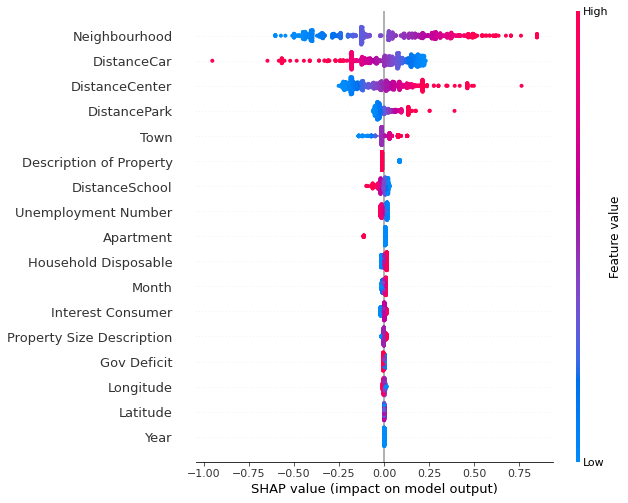

In [79]:
f = plt.figure()
shap.summary_plot(shap_values5, x_test_17)
f.savefig("summary_plot17cork.png", bbox_inches = 'tight', dpi = 600)

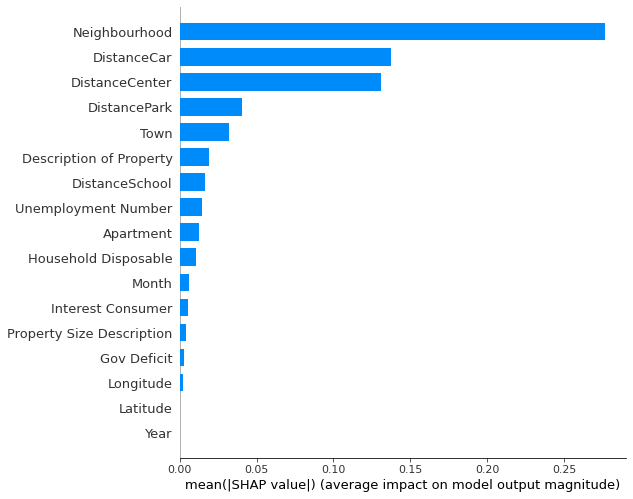

In [80]:
shap.summary_plot(shap_values5, x_train_17, plot_type = 'bar')

In [81]:
dfreal5 = pd.DataFrame(y_test_17.values)
dfpred5 = pd.DataFrame(y_predicted_17)

In [82]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df15 = pd.DataFrame(columns=cnames)

df15 = df15.append({'Algorithm': 'TPOT AutoML',
            'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [83]:
vis1 = pd.concat([df11, df12, df13, df14, df15], ignore_index=True)

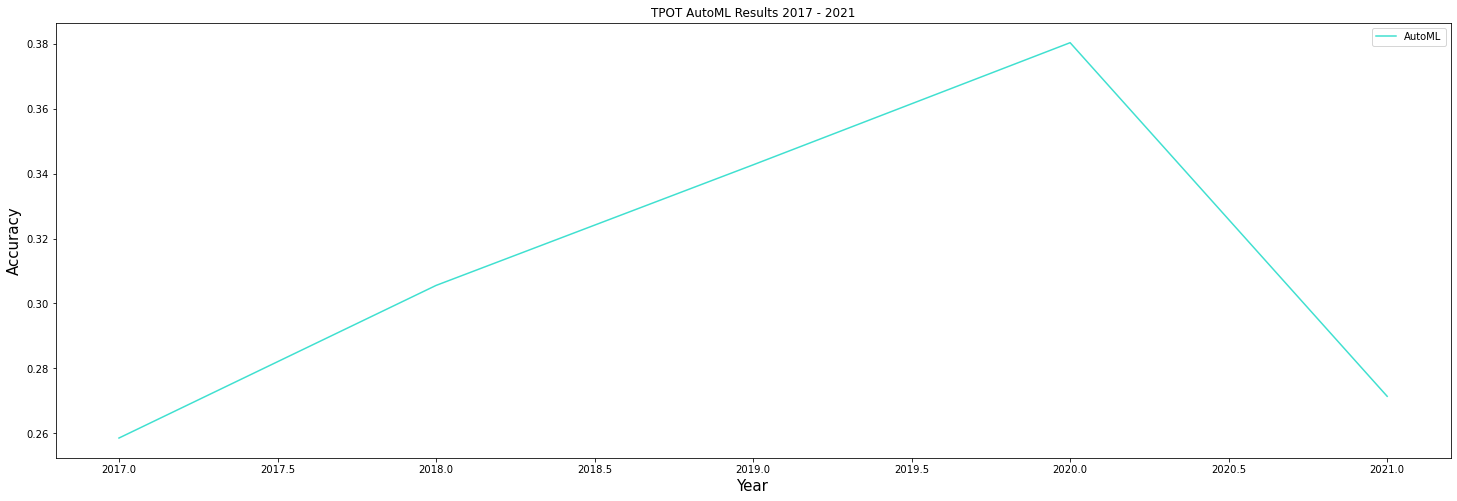

In [84]:
# don't need cross validation same training due to set intervals?
plt.subplots(figsize = (25, 8))
plt.plot(vis1['Year'], vis1['Accuracy'], label = 'AutoML', color = 'turquoise')
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title('TPOT AutoML Results 2017 - 2021')
plt.legend()
plt.show()

In [85]:
print("Mean accuracy for TPOT AutoML over period 2017-2021 is: " + str(vis1['Accuracy'].mean()))

Mean accuracy for TPOT AutoML over period 2017-2021 is: 0.3117049334695531


In [86]:
actual = pd.concat([dfreal1, dfreal2, dfreal3, dfreal4, dfreal5], ignore_index = True)
actual.rename(columns = {0: 'Actual'}, inplace = True)
actual.head()

,Actual
0,11.976659
1,12.421184
2,12.028739
3,12.570716
4,12.367341


In [87]:
pred = pd.concat([dfpred1, dfpred2, dfpred3, dfpred4, dfpred5], ignore_index = True)
pred.rename(columns={0: 'Predicted'}, inplace = True)
pred.head()

,Predicted
0,12.169406
1,12.365314
2,11.857791
3,12.080997
4,12.465157


In [88]:
actualvpred = actual.join(pred)

In [89]:
actualvpred.head()

,Actual,Predicted
0,11.976659,12.169406
1,12.421184,12.365314
2,12.028739,11.857791
3,12.570716,12.080997
4,12.367341,12.465157


In [90]:
exp = np.exp(actualvpred)

In [91]:
exp.shape

(3851, 2)

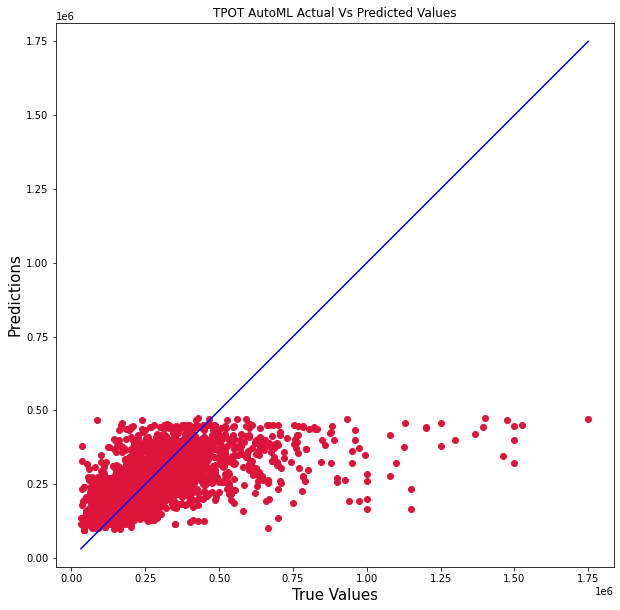

In [92]:
# plot predicted vs actual
## this is using actual prices hence adjusted scale compared to mljar plot
plt.figure(figsize = (10, 10))
plt.scatter(exp['Actual'], exp['Predicted'], c = 'crimson')

p1 = max(max(exp['Predicted']), max(exp['Actual']))
p2 = min(min(exp['Predicted']), min(exp['Actual']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
plt.title('TPOT AutoML Actual Vs Predicted Values')
plt.axis('equal')
plt.show()